In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import cumtrapz, trapz
import time
import scipy.stats as stats


#PYTHON MODULES
from constants import *
import gwcosmo
import gwpop
import gwutils
import utils
import sensitivity_curves as sc

#PLOTS
import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_cosmo_mass_evolution/"

#from matplotlib.ticker import ScalarFormatter
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

# Injection campaign

When starting an injection campaign to compute the sensitivity of a given detector we need to sample detector frame masses and luminosity distances from some fiducial distributions

We load our fiducial universe parameters

In [2]:
from fiducial_universe import *

Settings for the sensitivity of our detector

In [3]:
fmin = 10.
detector = 'O5'
det_Sc = sc.O5
based = 'ground'
snr_th = 8.

Find maximum detectable luminosity distance

In [4]:
mz_min,mz_max = 100.0, 500.0
log10dL_min,log10dL_max = np.log10(26000), np.log10(30000)

mzs = np.linspace(mz_min,mz_max,40)
dLs = np.logspace(log10dL_min,log10dL_max,40)
dL_hor = 0.
mz_hor = 0.

for i in range(len(mzs)):
    for j in range(len(dLs)):
        snr = gwutils.vsnr(mzs[i],mzs[i],dLs[j],fmin,Tobs_fid,det_Sc,based)
        if snr > snr_th:
            if dLs[j] > dL_hor:
                dL_hor = dLs[j]
                mz_hor = mzs[j]
print(dL_hor,mz_hor)

26481.40530329358 151.28205128205127


In [5]:
data_hor_O5 = np.genfromtxt('gw_horizon_data/zhor_max_o5_mobs.txt')
mtotz_hor_O5 = data_hor_O5[:,0]
z_hor_O5 = data_hor_O5[:,1]

We sample in :
- Uniform log dL
- Power law for detector primary mass 
- Uniforma mass ratio

In [6]:
params = 'm1z_m2z_dL'

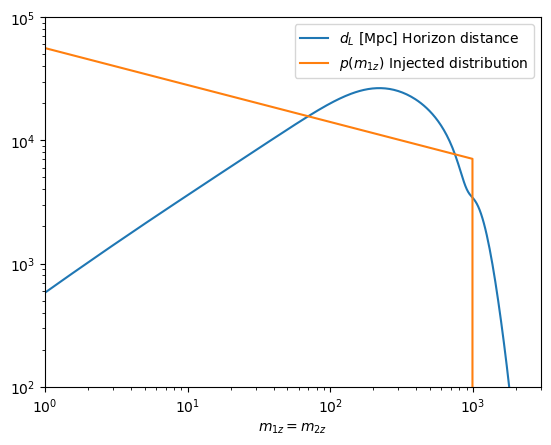

In [7]:

plt.loglog(mtotz_hor_O5/2,gwcosmo.dL_approx(z_hor_O5,H0_fid,Om0_fid),label=r'$d_L$ [Mpc] Horizon distance')

#Parameters for the injection are tunned by hand
alpha_inj, mmin_inj, mmax_inj = -.3, 1., 1000.


plt.loglog(mtotz_hor_O5/2,1e7*gwpop.power_law(mtotz_hor_O5/2,alpha_inj, mmin_inj,mmax_inj),label=r'$p(m_{1z})$ Injected distribution')

plt.ylim([1e2,1e5])
plt.xlim([1,3e3])
plt.xlabel(r'$m_{1z}=m_{2z}$')
#plt.ylabel(r'')
plt.legend()
plt.show()

For the injections we want to:

- which injections are detected, as determined by observed SNR* larger than a fixed threshold
- the probability of each draw given the injected distributions

For the detector frame masses we are sampling with a power-law in the primary mass:

$$p(m_{1z})=\frac{(1+\alpha)}{(m_{1z,max})^{(1+\alpha)}-(m_{1z,min})^{(1+\alpha)}}m_{1z}^\alpha$$

, and uniform in the mass ratio:

$$p(q)=1$$

Since we are sampling uniformly in $\log_{10} d_L$ we need to include a Jacobian to transform to $d_L$:

$$p(d_L)=p'(\log_{10} d_L)|\frac{\partial \log_{10} d_L}{\partial d_L}|=\frac{1}{(\log_{10}d_{L}^{max}-\log_{10}d_L^{min})}\frac{\log_{10}e}{d_L}$$

In total

$$p_{draw}(m_{1z},d_L)=p(m_{1z})p(m_{2z})p(d_L)$$

The observed SNR is defined as a random instance of a normal distribution centered at the true SNR with variance 1. 

The true SNR is computed from the optimal SNR multiplied by the geometrical factor accounting for the random sky postion, inclination and polarization for a given detector network.

We do injections for $m_{1z}$, $m_{2z}$ and $d_L$

In [10]:
n_detections = int(1e4)
n_sources = n_detections*50


starttime = time.time()

##Defining the injected distribution CDFs
m1zs = np.linspace(mmin_inj,mmax_inj,10000)
cdf_m1z = cumtrapz(gwpop.power_law(m1zs,alpha_inj, mmin_inj,mmax_inj),m1zs,initial=0.0)
cdf_m1z = cdf_m1z / cdf_m1z[-1]
#Geometric factor from orientations
ww = np.linspace(0.0,1.0,1000)
cdf_ww = 1.0-gwutils.pw_hl(ww)

##Computing injected events
#----
#Detector frame primary mass
mz_min,mz_max = mmin_inj,mmax_inj
m1z_mock_pop = utils.inverse_transf_sampling(cdf_m1z,m1zs,n_sources)
m2z_mock_pop = np.random.uniform(mz_min,m1z_mock_pop,n_sources)
#Luminosity distance
log10dL_min,log10dL_max = 1., np.log10(27000.0)
log10dL_mock_pop = np.random.uniform(log10dL_min,log10dL_max,n_sources)
dL_mock_pop = np.power(10.0,log10dL_mock_pop)

#Optimal SNR
snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs_fid,det_Sc,based)
#True SNR
w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
#Observed SNR
snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

##Computing p_draw
p_draw_m1z = gwpop.power_law(m1z_mock_pop,alpha_inj, mmin_inj,mmax_inj)
p_draw_m2z = 1./(m1z_mock_pop-mz_min)
p_draw_logdL = 1./(log10dL_max-log10dL_min)
jac_logdLdL = np.log10(np.exp(1.))/dL_mock_pop
p_draw_mock_pop = p_draw_m1z * p_draw_logdL * jac_logdLdL * p_draw_m2z

#Detected injections
m1z_mock = m1z_mock_pop[snr_obs_mock_pop>snr_th]
m2z_mock = m2z_mock_pop[snr_obs_mock_pop>snr_th]
dL_mock = dL_mock_pop[snr_obs_mock_pop>snr_th]
p_draw_mock = p_draw_mock_pop[snr_obs_mock_pop>snr_th]

Ndet = np.size(m1z_mock)
Ndraws = n_sources
print('Ndet = ',Ndet,', Ndraw = ',Ndraws)
print('Time taken = {} seconds'.format(time.time() - starttime))

In [ ]:
np.savetxt('data_injections/injections_'+detector+'_'+params+'_Ndraws_%s_Ndet_%s.txt' % (Ndraws,Ndet),np.column_stack((m1z_mock,m2z_mock,dL_mock,p_draw_mock)),delimiter = ' ')
